In [ ]:
!pip install --quiet git+https://github.com/atagade/lucent

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.6 MB/s eta 0:00:00


In [ ]:
import torch
import urllib.request 
import numpy as np
import collections
from functools import partial
from PIL import Image
from lucent.modelzoo import custom_resnet
from lucent.optvis import objectives, transform, param, render
from lucent.optvis.render import hook_model
from transformers import ViTImageProcessor, ViTForImageClassification, AutoConfig

In [ ]:
import urllib.request  # the lib that handles the url stuff
labels_str = ""
for line in urllib.request.urlopen("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt"):
    labels_str += line.decode('utf-8')
labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [ ]:
!wget https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg

--2023-06-03 15:17:31--  https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg
Resolving distill.pub (distill.pub)... 151.101.1.195, 151.101.65.195
Connecting to distill.pub (distill.pub)|151.101.1.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17153 (17K) [image/jpeg]
Saving to: ‘dog_cat.jpeg.1’

dog_cat.jpeg.1      100%[===================>]  16.75K  --.-KB/s    in 0s      

2023-06-03 15:17:31 (95.7 MB/s) - ‘dog_cat.jpeg.1’ saved [17153/17153]



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', output_attentions = True, output_hidden_states = True).to(device).eval()

In [ ]:
img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
img = img / 255
img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
normalize = (
    transform.preprocess_inceptionv1()
    if model._get_name() == "InceptionV1"
    else transform.normalize()
)
transforms = [
    normalize,
    torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
]

transforms_f = transform.compose(transforms)
img = img.unsqueeze(0)
img = transforms_f(img)

scores = model.forward(img)

In [ ]:
label = 'Labrador retriever'
acts = scores.attentions[9]
score = scores.logits[0, labels.index(label)]
grad = torch.autograd.grad(score, acts)[0]

In [ ]:
attr = torch.sum(acts[0] * grad, axis = -1)

In [ ]:
attr.mean(dim=1)

tensor([[ 4.6001e-03,  1.7264e-06,  2.2458e-04,  5.4890e-04,  7.0247e-06,
         -7.3564e-05,  6.3577e-06, -1.4766e-05,  1.4907e-08, -2.5794e-06,
         -5.8909e-06, -4.4808e-06, -5.6537e-06, -7.2722e-06, -8.4064e-06,
          3.7708e-04,  8.0677e-04, -1.1686e-04,  5.0305e-04,  5.1540e-04,
         -1.1427e-06,  6.1394e-06, -3.3750e-06, -3.2353e-07,  1.6398e-06,
          2.5649e-06, -1.1910e-07, -2.1254e-06, -3.9222e-06,  9.1313e-04,
         -6.2148e-05,  3.2267e-04,  2.8934e-04,  1.6320e-04,  9.4953e-05,
          6.2766e-06,  1.0445e-05,  1.0144e-05, -1.9842e-05,  6.7184e-07,
          3.8502e-06,  1.8444e-06,  2.6684e-07,  8.0048e-04,  3.6142e-04,
          8.5196e-04,  2.7362e-04,  4.3835e-04,  1.0462e-04,  1.8527e-05,
          9.6121e-06,  8.3640e-06, -2.1825e-05,  8.5275e-06,  4.4809e-06,
          2.8031e-06,  1.4008e-06,  8.4080e-04,  9.7972e-04,  1.7768e-03,
          7.7091e-04,  1.4765e-04,  7.9439e-04,  1.1093e-05, -1.9330e-05,
         -5.8205e-05,  4.3907e-04, -1.

In [ ]:
(attr.mean(dim=1) == attr.mean(dim=1).max()).nonzero()

tensor([[0, 0]], device='cuda:0')

100%|██████████| 2048/2048 [02:28<00:00, 13.75it/s]



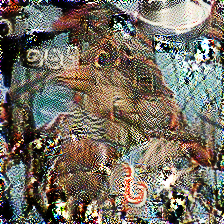
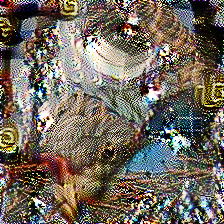

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()


param_f = lambda: param.image(224, batch=2)
layer = '9'

obj = objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_query', 0) +  objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_key', 1)

_ = render.render_vis(model, obj, param_f, preprocess = True, show_inline = True, fixed_image_size=(224,224), thresholds=(2048,))

## One Cell

tensor([0, 0], device='cuda:0')


100%|██████████| 512/512 [01:13<00:00,  6.93it/s]



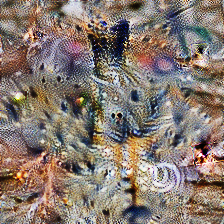
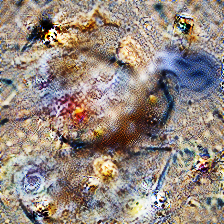
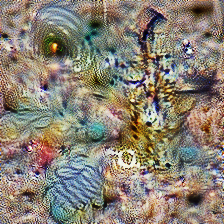
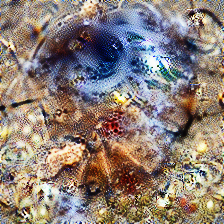

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', output_attentions = True, output_hidden_states = True).to(device)

layer = '11'

img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
img = img / 255
img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
normalize = (
    transform.preprocess_inceptionv1()
    if model._get_name() == "InceptionV1"
    else transform.normalize()
)
transforms = [
    normalize,
    torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
]

transforms_f = transform.compose(transforms)
img = img.unsqueeze(0)
img = transforms_f(img)

scores = model.forward(img)

label = 'Labrador retriever'
acts = scores.hidden_states[int(layer)]
score = scores.logits[0, labels.index(label)]
grad = torch.autograd.grad(score, acts)[0]

attr = torch.sum(acts[0] * grad, axis = -1)

channel_list = (attr == attr.max()).nonzero()[0]
print(channel_list)

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

param_f = lambda: param.image(224, batch=2*len(channel_list))

obj = objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_query', channel_list[0], batch=0) + objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_key', channel_list[0], batch=1)  

for i, channel in enumerate(channel_list):
  if i == 0:
    continue

  obj += objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_query', channel, batch=i*2) + objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_key', channel, batch=i*2 + 1)

_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))


Layer 0: Key and Value Feature Visualisations
The maximally activating channels are: tensor([  0,   4, 171], device='cuda:0')


100%|██████████| 512/512 [00:41<00:00, 12.46it/s]



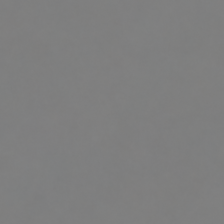
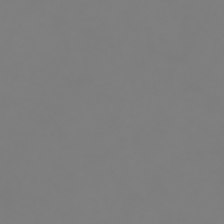
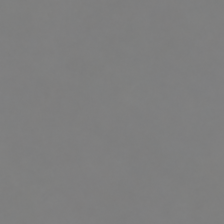
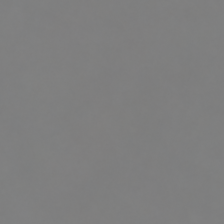
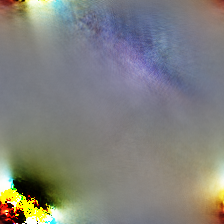
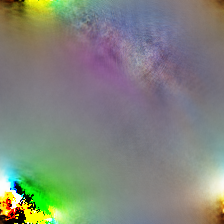

Layer 1: Key and Value Feature Visualisations
The maximally activating channels are: tensor([  0,   4, 171], device='cuda:0')


100%|██████████| 512/512 [00:45<00:00, 11.26it/s]



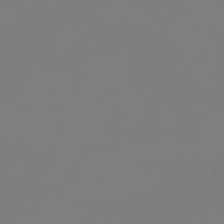
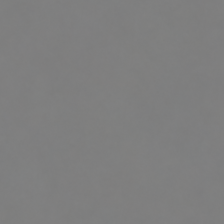
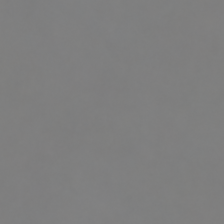
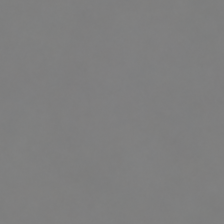
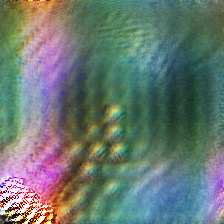
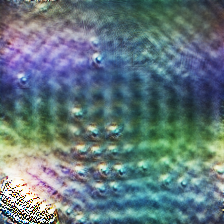

Layer 2: Key and Value Feature Visualisations
The maximally activating channels are: tensor([  0,   7, 171], device='cuda:0')


100%|██████████| 512/512 [00:50<00:00, 10.07it/s]



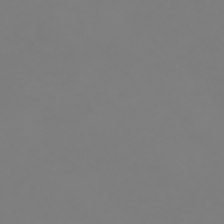
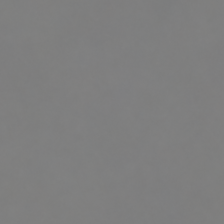
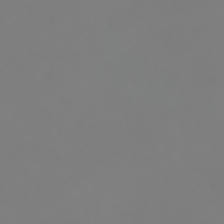
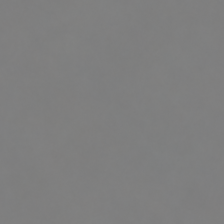
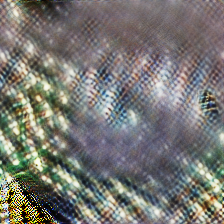
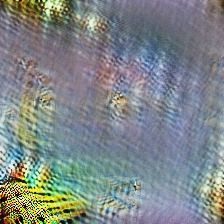

Layer 3: Key and Value Feature Visualisations
The maximally activating channels are: tensor([  0,   8, 171], device='cuda:0')


100%|██████████| 512/512 [00:55<00:00,  9.15it/s]



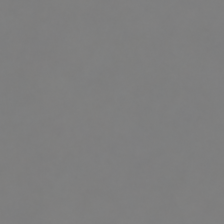
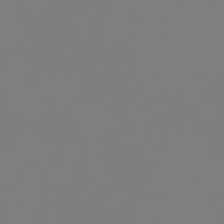
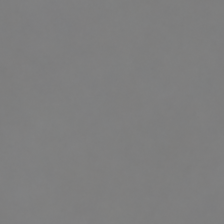
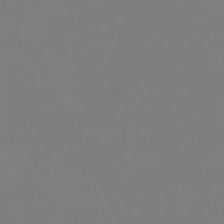
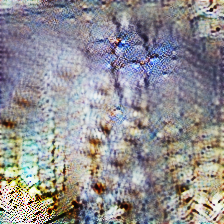
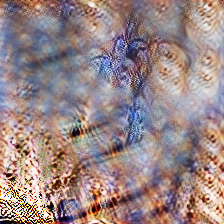

Layer 4: Key and Value Feature Visualisations
The maximally activating channels are: tensor([  0,   2, 171], device='cuda:0')


  0%|          | 1/512 [00:00<02:26,  3.49it/s]


OutOfMemoryError: ignored

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

layers = 12

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', output_attentions = True, output_hidden_states = True).to(device)

img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
img = img / 255
img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
normalize = (
    transform.preprocess_inceptionv1()
    if model._get_name() == "InceptionV1"
    else transform.normalize()
)
transforms = [
    normalize,
    torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
]

transforms_f = transform.compose(transforms)
img = img.unsqueeze(0)
img = transforms_f(img)

scores = model.forward(img)

for layer in range(layers):

  print(f'Layer {layer}: Key and Value Feature Visualisations')

  label = 'Labrador retriever'
  acts = scores.attentions[layer]
  score = scores.logits[0, labels.index(label)]
  grad = torch.autograd.grad(score, acts)[0]

  attr = torch.sum(acts[0] * grad, axis = -1)

  channel_list = (attr == attr.max()).nonzero()[0]
  print(f'The maximally activating channels are: {channel_list}')

  layer = str(layer)

  param_f = lambda: param.image(224, batch=2*len(channel_list))

  obj = objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_query', channel_list[0], batch=0) + objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_key', channel_list[0], batch=1)  

  for i, channel in enumerate(channel_list):
    if i == 0:
      continue

    obj = objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_query', channel, batch=i*2) + objectives.channel('vit_encoder_layer_'+layer+'_attention_attention_key', channel, batch=i*2 + 1)

  _ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))
